In [1]:
from window_generator import WindowGenerator
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
# from read_data import *
from process_data import *
from methods import *
MAX_EPOCHS = 30
VOICE = 0

In [31]:
def compile_and_fit(model, window, patience=2, verbose=0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                     restore_best_weights=True)
#  Early stopping when there is no improvement in loss. 
    model.compile(loss=tf.losses.CategoricalCrossentropy(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.CategoricalAccuracy(), tf.metrics.CategoricalCrossentropy(),tf.metrics.MeanAbsoluteError()])

# At the end of each epoch, the model will iterate over the validation dataset and compute the validation loss and validation metrics.
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping],
                        verbose=verbose)
    return history

In [32]:
multi_step_window = WindowGenerator(input_width=54, label_width=1, shift=1, batch_size=20, voice_number=VOICE, shuffle=True)

for example_inputs, example_labels in multi_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

print(multi_step_window.train)
# print(len(multi_step_window.label_columns_indices))

Inputs shape (batch, time, features): (20, 54, 25)
Labels shape (batch, time, features): (20, 20)
<MapDataset shapes: ((None, 54, 25), (None, 20)), types: (tf.float32, tf.float32)>


In [33]:
n_output_nodes = len(multi_step_window.label_columns_indices)

initializer = tf.keras.initializers.RandomUniform(minval=-0.01, maxval=0.01)
linear_multi_step = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, kernel_initializer=initializer, activation='relu'),
#     tf.keras.layers.Dense(units=32, kernel_initializer=initializer, activation='relu'),
#     tf.keras.layers.Dense(units=32, kernel_initializer=initializer, activation='relu'),
    tf.keras.layers.Dense(units=n_output_nodes, kernel_initializer=initializer, activation='softmax'),
])
print('Input shape:', multi_step_window.example[0].shape)
print('Output shape:', linear_multi_step(multi_step_window.example[0]).shape)

# Train the model
ffnn_history = compile_and_fit(linear_multi_step, multi_step_window, verbose=0)

print('Note that these are the LAST model metrics and not the BEST model metrics because of early stopping with restore_best_weights ')
print(
    "epochs: {}, loss: {:0.4f}, mean_absolute_error: {:0.4f}, val_loss: {:0.4f}, val_mean_absolute_error: {:0.4f}".format(
        len(history.history['loss']),
        history.history["loss"][-1],
        history.history["mean_absolute_error"][-1],
        history.history["val_loss"][-1],
        history.history["val_mean_absolute_error"][-1],
    )
)

# Evaluate the model
print("Evaluate")
result = linear_multi_step.evaluate(multi_step_window.test)
dict(zip(linear_multi_step.metrics_names, result))

Input shape: (20, 54, 25)
Output shape: (20, 20)
Note that these are the LAST model metrics and not the BEST model metrics because of early stopping with restore_best_weights 
epochs: 14, loss: 0.6613, mean_absolute_error: 0.0288, val_loss: 0.7747, val_mean_absolute_error: 0.0357
Evaluate
13/13 [==============================] - 0s 2ms/step - loss: 1.3474 - categorical_accuracy: 0.6585 - categorical_crossentropy: 1.3474 - mean_absolute_error: 0.0377


{'loss': 1.3474388122558594,
 'categorical_accuracy': 0.6585366129875183,
 'categorical_crossentropy': 1.3474388122558594,
 'mean_absolute_error': 0.03767094388604164}

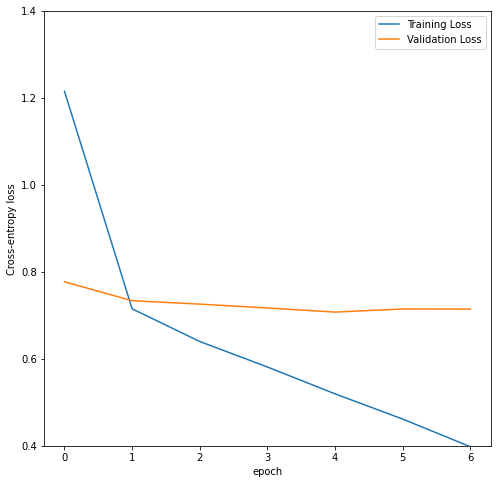

In [40]:
acc = ffnn_history.history['categorical_accuracy']
val_acc = ffnn_history.history['val_categorical_accuracy']

loss = ffnn_history.history['loss']
val_loss = ffnn_history.history['val_loss']

epochs_range = range(len(ffnn_history.history['loss']))

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.xlabel('epoch')
# plt.ylabel('Categorical Accuracy')
# plt.ylim(0.7,0.9)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')

plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0.4, 1.4)
plt.legend(loc='upper right')
plt.savefig('img/ffnn_loss.png')
plt.show()

In [35]:
n_output_nodes = len(multi_step_window.label_columns_indices)

rnn = tf.keras.Sequential([
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(units=n_output_nodes, activation='softmax'),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', multi_step_window.example[0].shape)
print('Output shape:', rnn(multi_step_window.example[0]).shape)

# Train the model
history = compile_and_fit(rnn, multi_step_window, verbose=1)

print('Note that these are the LAST model metrics and not the BEST model metrics because of early stopping with restore_best_weights ')
print(
    "epochs: {}, loss: {:0.4f}, mean_absolute_error: {:0.4f}, val_loss: {:0.4f}, val_mean_absolute_error: {:0.4f}".format(
        len(history.history['loss']),
        history.history["loss"][-1],
        history.history["mean_absolute_error"][-1],
        history.history["val_loss"][-1],
        history.history["val_mean_absolute_error"][-1],
    )
)

# Evaluate the model
print("Evaluate")
result = rnn.evaluate(multi_step_window.test)
dict(zip(rnn.metrics_names, result))

Input shape: (20, 54, 25)
Output shape: (20, 20)
Epoch 1/30
103/103 [==============================] - 6s 34ms/step - loss: 1.6859 - categorical_accuracy: 0.6859 - categorical_crossentropy: 1.6859 - mean_absolute_error: 0.0613 - val_loss: 0.8486 - val_categorical_accuracy: 0.8242 - val_categorical_crossentropy: 0.8486 - val_mean_absolute_error: 0.0345
Epoch 2/30
103/103 [==============================] - 3s 28ms/step - loss: 0.8986 - categorical_accuracy: 0.7997 - categorical_crossentropy: 0.8986 - mean_absolute_error: 0.0368 - val_loss: 0.8448 - val_categorical_accuracy: 0.8242 - val_categorical_crossentropy: 0.8448 - val_mean_absolute_error: 0.0339
Epoch 3/30
103/103 [==============================] - 3s 29ms/step - loss: 0.8424 - categorical_accuracy: 0.8093 - categorical_crossentropy: 0.8424 - mean_absolute_error: 0.0340 - val_loss: 0.8469 - val_categorical_accuracy: 0.8242 - val_categorical_crossentropy: 0.8469 - val_mean_absolute_error: 0.0353
Epoch 4/30
103/103 [================

{'loss': 1.1604222059249878,
 'categorical_accuracy': 0.6910569071769714,
 'categorical_crossentropy': 1.1604222059249878,
 'mean_absolute_error': 0.03786442056298256}

In [5]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                23040     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 24,340
Trainable params: 24,340
Non-trainable params: 0
_________________________________________________________________


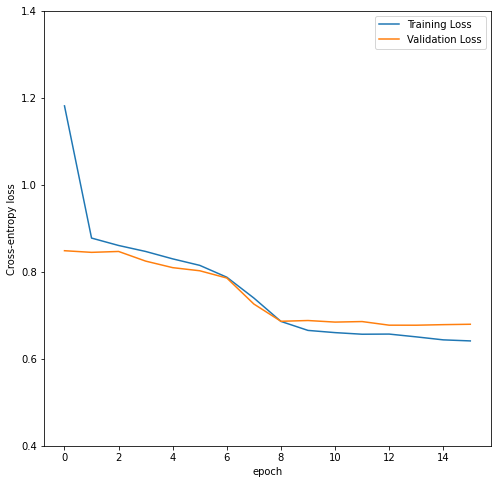

In [39]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.ylim(0.4, 1.4)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.savefig('img/rnn_loss.png')
plt.show()

In [41]:
# Get last window
def predict_new_pitches(model, n=100):
    last_window = None
    last_pitch = None
    all_predicted_pitches = []
    all_probs = []

    for i in range(n):
        if last_window is None:
            # Use an iterator to get the last window of the dataset. 
            for last_window, labels in multi_step_window.test_no_shuffle.as_numpy_iterator():
                pass

        # Add dimension to input
        probabilities = model.predict(np.array([last_window]))[0]
        all_probs.append(np.array(probabilities))
        
        predicted_shift = get_shift_from_probability(
            probabilities,
            key=multi_step_window.shift_conversion_key,
            method=SelectionMethod.PROB, n=10,
        )
        
        # Get latest pitch of the dataset
        if last_pitch is None:
            last_pitch = get_voice(VOICE)[-1]
            
        predicted_pitch = last_pitch + predicted_shift
        all_predicted_pitches.append(predicted_pitch)
        
        pitch_features = get_pitch_features(predicted_pitch, VOICE)
        shift_one_hot = [0] * len(multi_step_window.shift_conversion_key)
        shift_one_hot[multi_step_window.shift_conversion_key.index(predicted_shift)] = 1

        last_pitch = predicted_pitch

        # create new dataframe
        new_df = pd.DataFrame(dtype=float, index=[0])
        (
            new_df["log_pitch"],
            new_df["chroma_x"],
            new_df["chroma_y"],
            new_df["c5_x"],
            new_df["c5_y"],
        ) = pitch_features
        
        # - Normalise features
        new_df = (new_df - multi_step_window.mean_train) / multi_step_window.std_train
        features = new_df.values.tolist()[0] + shift_one_hot
        # - Make new window based on previous timesteps with a slide of 1 and the normalised features
        last_window = np.append(last_window[1:], [features], axis=0)
    return all_predicted_pitches, all_probs

In [44]:
predictions, probs = predict_new_pitches(linear_multi_step, n=500)
print(predictions)

[68, 67, 67, 67, 67, 67, 67, 67, 67, 69, 69, 70, 70, 68, 68, 68, 68, 70, 70, 68, 68, 70, 70, 71, 71, 69, 69, 68, 68, 66, 66, 64, 64, 66, 66, 64, 64, 64, 64, 64, 64, 62, 62, 62, 62, 61, 61, 60, 60, 58, 58, 59, 59, 59, 59, 61, 61, 64, 64, 64, 64, 62, 62, 63, 63, 64, 64, 67, 67, 66, 66, 64, 64, 65, 65, 67, 67, 67, 67, 67, 67, 65, 65, 67, 67, 68, 68, 68, 68, 66, 66, 66, 66, 68, 68, 70, 70, 71, 71, 71, 71, 70, 70, 68, 68, 66, 66, 64, 64, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 66, 66, 67, 67, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 68, 68, 66, 66, 64, 64, 63, 63, 61, 61, 61, 61, 63, 63, 63, 63, 63, 63, 64, 64, 66, 66, 66, 66, 64, 64, 64, 64, 62, 62, 61, 61, 63, 63, 65, 65, 58, 58, 60, 60, 62, 62, 62, 62, 63, 63, 64, 64, 64, 64, 64, 64, 65, 65, 66, 66, 68, 68, 69, 69, 67, 67, 65, 65, 67, 67, 67, 67, 68, 68, 68, 68, 63, 63, 63, 63, 61, 61, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 66, 66, 68, 68, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 70,

In [45]:
with open('ffnn_output_voice0.txt', 'a') as the_file:
    for p in predictions:
        the_file.write(str(p) + '\n')

In [9]:
print(probs[0], sum(probs[0]))

[9.99815047e-01 2.57839911e-05 1.43231555e-05 1.30847786e-06
 4.75635364e-10 3.54383360e-06 4.92685337e-10 5.63399425e-08
 1.33819356e-08 1.07440620e-07 5.79618264e-09 4.84886264e-09
 3.22758775e-09 4.03254635e-05 9.38014182e-06 4.70555648e-08
 6.78563038e-06 4.90289254e-10 2.19329710e-08 8.33227605e-05] 1.0000000817237185
